## ResNet101

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-18 11:10:06.353170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 11:10:06.401261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 11:10:06.445955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 11:10:06.446246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3338586713810101233
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14355857408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11565486670458986089
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet101

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import math

In [12]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'
checkpointPath = '../checkpoints/epoch_{epoch:04d}.ckpt'
logsPath = '../logs/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../model/best/best_model'

batchSize = 32
imageWidth = 224
imageHeight = 224
imageChannel = 3
dropRate = 0.0


### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [4]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=20,
                                  zoom_range=0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest',
                                  )

train set

In [5]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 7108 images belonging to 50 classes.


validation set

In [6]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
)

Found 870 images belonging to 50 classes.


ImageDataGenerator (train, validation)

In [7]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [8]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 929 images belonging to 50 classes.


make model

In [14]:
model = tf.keras.Sequential([
  ResNet101(include_top=False, weights='imagenet', input_shape=(imageWidth, imageHeight, imageChannel)),
  GlobalAveragePooling2D(),
  Dropout(rate=dropRate),
  Dense(1024, activation='relu' ),
  Dropout(rate=dropRate),
  Dense(512, activation='relu' ),
  Dropout(rate=dropRate),
  Dense(256, activation='relu' ),
  Dense(50, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                      

model compile

In [15]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

difine callbacks

In [16]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [17]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss', patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [18]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath, histogram_freq=1)

model fit

In [19]:
epochs = 200
history = model.fit(
    trainGenSet,
    epochs=epochs,
    validation_data=validationGenSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

Epoch 1/200


2022-06-18 11:18:26.934562: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


223/223 [==============================] - ETA: 0s - loss: 1.4160 - accuracy: 0.6284

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets
2022-06-18 11:30:33.877931: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.
2022-06-18 11:30:33.918087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31457280 exceeds 10% of free system memory.
2022-06-18 11:30:34.006993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.
2022-06-18 11:30:34.102867: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.
2022-06-18 11:30:34.195516: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35389440 exceeds 10% of free system memory.


223/223 [==============================] - 749s 3s/step - loss: 1.4160 - accuracy: 0.6284 - val_loss: 444.6359 - val_accuracy: 0.0195
Epoch 2/200
223/223 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8958

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 771s 3s/step - loss: 0.3612 - accuracy: 0.8958 - val_loss: 16.4025 - val_accuracy: 0.0287
Epoch 3/200
223/223 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9216

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 719s 3s/step - loss: 0.2846 - accuracy: 0.9216 - val_loss: 5.0555 - val_accuracy: 0.0253
Epoch 4/200
223/223 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9406

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 749s 3s/step - loss: 0.2012 - accuracy: 0.9406 - val_loss: 2.7453 - val_accuracy: 0.3184
Epoch 5/200
223/223 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9665

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 715s 3s/step - loss: 0.1196 - accuracy: 0.9665 - val_loss: 1.2942 - val_accuracy: 0.7506
Epoch 6/200
223/223 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9605

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


223/223 [==============================] - 672s 3s/step - loss: 0.1505 - accuracy: 0.9605 - val_loss: 2.5587 - val_accuracy: 0.4862
Epoch 7/200
223/223 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9664

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


223/223 [==============================] - 673s 3s/step - loss: 0.1201 - accuracy: 0.9664 - val_loss: 1.4703 - val_accuracy: 0.7161
Epoch 8/200
223/223 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9626

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


223/223 [==============================] - 748s 3s/step - loss: 0.1465 - accuracy: 0.9626 - val_loss: 2.7326 - val_accuracy: 0.4747
Epoch 9/200
223/223 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9754

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 759s 3s/step - loss: 0.0904 - accuracy: 0.9754 - val_loss: 0.3796 - val_accuracy: 0.8931
Epoch 10/200
223/223 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9660

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


223/223 [==============================] - 687s 3s/step - loss: 0.1315 - accuracy: 0.9660 - val_loss: 0.4269 - val_accuracy: 0.9172
Epoch 11/200
223/223 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9733

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 773s 3s/step - loss: 0.1008 - accuracy: 0.9733 - val_loss: 0.3768 - val_accuracy: 0.9011
Epoch 12/200
223/223 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9731

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


223/223 [==============================] - 689s 3s/step - loss: 0.1007 - accuracy: 0.9731 - val_loss: 3.6230 - val_accuracy: 0.5046
Epoch 13/200
223/223 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9748

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


223/223 [==============================] - 692s 3s/step - loss: 0.0909 - accuracy: 0.9748 - val_loss: 0.8677 - val_accuracy: 0.8494
Epoch 14/200
223/223 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9848

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


INFO:tensorflow:Assets written to: ../model/best/best_model/assets


223/223 [==============================] - 727s 3s/step - loss: 0.0523 - accuracy: 0.9848 - val_loss: 0.1174 - val_accuracy: 0.9713
Epoch 15/200
223/223 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9752

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


223/223 [==============================] - 679s 3s/step - loss: 0.0986 - accuracy: 0.9752 - val_loss: 2.4505 - val_accuracy: 0.5207
Epoch 16/200
223/223 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9638

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


223/223 [==============================] - 675s 3s/step - loss: 0.1366 - accuracy: 0.9638 - val_loss: 1.9944 - val_accuracy: 0.7184
Epoch 17/200
223/223 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9806

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


223/223 [==============================] - 669s 3s/step - loss: 0.0745 - accuracy: 0.9806 - val_loss: 6.7178 - val_accuracy: 0.2977
Epoch 18/200
223/223 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9792

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


223/223 [==============================] - 681s 3s/step - loss: 0.0836 - accuracy: 0.9792 - val_loss: 0.4472 - val_accuracy: 0.9103
Epoch 19/200
223/223 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9886

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


223/223 [==============================] - 692s 3s/step - loss: 0.0504 - accuracy: 0.9886 - val_loss: 0.7081 - val_accuracy: 0.8851
Epoch 20/200
223/223 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9797

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


223/223 [==============================] - 688s 3s/step - loss: 0.0785 - accuracy: 0.9797 - val_loss: 3.2133 - val_accuracy: 0.5609
Epoch 21/200
223/223 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9689

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


223/223 [==============================] - 689s 3s/step - loss: 0.1237 - accuracy: 0.9689 - val_loss: 0.7356 - val_accuracy: 0.8276
Epoch 22/200
223/223 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9827

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


223/223 [==============================] - 680s 3s/step - loss: 0.0697 - accuracy: 0.9827 - val_loss: 0.1480 - val_accuracy: 0.9667
Epoch 23/200
223/223 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9848

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


223/223 [==============================] - 685s 3s/step - loss: 0.0605 - accuracy: 0.9848 - val_loss: 0.3354 - val_accuracy: 0.9172
Epoch 24/200
223/223 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9802

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


223/223 [==============================] - 682s 3s/step - loss: 0.0894 - accuracy: 0.9802 - val_loss: 1.6827 - val_accuracy: 0.6977


In [20]:
scores = model.evaluate(testGenSet)
print(scores)

30/30 [==============================] - 67s 2s/step - loss: 1.5783 - accuracy: 0.6846
[1.5783251523971558, 0.6846070885658264]


In [21]:
testLoss, testAccuracy = model.evaluate(testGenSet, verbose=0)

print("test_loss:", testLoss, "test_accuracy:", testAccuracy)

test_loss: 1.5783250331878662 test_accuracy: 0.6846070885658264


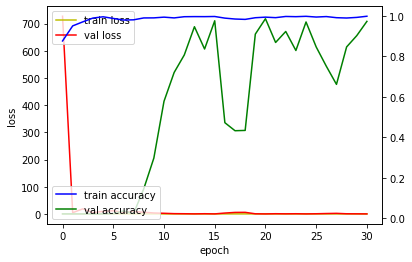

In [17]:


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

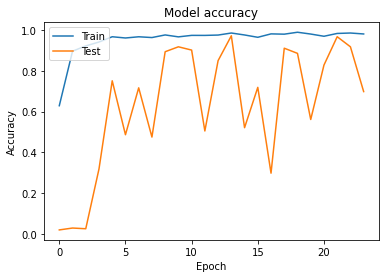

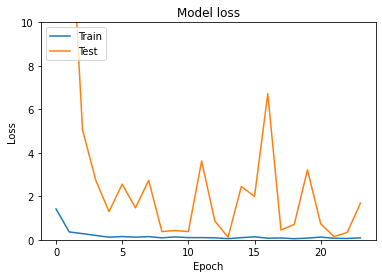

In [22]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
model.save('../model/resnetModel')

INFO:tensorflow:Assets written to: ../model/resnetModel/assets


INFO:tensorflow:Assets written to: ../model/resnetModel/assets


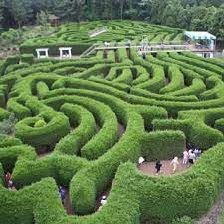

In [24]:
testImage = load_img("../testImage.jpg", target_size = (imageHeight, imageWidth))
testImage

In [25]:
testImage = img_to_array(testImage)
testImage = testImage/255.0

print(testImage)

[[[0.2627451  0.32941177 0.30588236]
  [0.22745098 0.29411766 0.27058825]
  [0.28627452 0.34901962 0.34509805]
  ...
  [0.34117648 0.40784314 0.43529412]
  [0.36862746 0.4392157  0.45490196]
  [0.36862746 0.44705883 0.4392157 ]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.27058825 0.24705882]
  [0.29803923 0.36078432 0.35686275]
  ...
  [0.28235295 0.3529412  0.36862746]
  [0.32156864 0.39215687 0.4       ]
  [0.29803923 0.3764706  0.36862746]]

 [[0.4        0.46666667 0.44313726]
  [0.36862746 0.43529412 0.4117647 ]
  [0.43529412 0.49803922 0.49411765]
  ...
  [0.30588236 0.3764706  0.3764706 ]
  [0.28627452 0.36078432 0.3529412 ]
  [0.34901962 0.43137255 0.40392157]]

 ...

 [[0.18039216 0.2784314  0.16078432]
  [0.18039216 0.2784314  0.16078432]
  [0.17254902 0.27058825 0.15294118]
  ...
  [0.5137255  0.56078434 0.40392157]
  [0.4862745  0.53333336 0.3764706 ]
  [0.49411765 0.5411765  0.4       ]]

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]


In [26]:
confidence = model.predict(testImage.reshape((1, imageHeight, imageWidth, imageChannel)))

1/1 [==============================] - 2s 2s/step


In [27]:
for i in range(confidence.shape[1]):
    print(f"{i} 일 확률 = {round(confidence[0][i], 3)}")

print(f"정답은 : {np.argmax(confidence, axis=1)}")

0 일 확률 = 0.0
1 일 확률 = 0.0
2 일 확률 = 0.0
3 일 확률 = 0.0
4 일 확률 = 1.0
5 일 확률 = 0.0
6 일 확률 = 0.0
7 일 확률 = 0.0
8 일 확률 = 0.0
9 일 확률 = 0.0
10 일 확률 = 0.0
11 일 확률 = 0.0
12 일 확률 = 0.0
13 일 확률 = 0.0
14 일 확률 = 0.0
15 일 확률 = 0.0
16 일 확률 = 0.0
17 일 확률 = 0.0
18 일 확률 = 0.0
19 일 확률 = 0.0
20 일 확률 = 0.0
21 일 확률 = 0.0
22 일 확률 = 0.0
23 일 확률 = 0.0
24 일 확률 = 0.0
25 일 확률 = 0.0
26 일 확률 = 0.0
27 일 확률 = 0.0
28 일 확률 = 0.0
29 일 확률 = 0.0
30 일 확률 = 0.0
31 일 확률 = 0.0
32 일 확률 = 0.0
33 일 확률 = 0.0
34 일 확률 = 0.0
35 일 확률 = 0.0
36 일 확률 = 0.0
37 일 확률 = 0.0
38 일 확률 = 0.0
39 일 확률 = 0.0
40 일 확률 = 0.0
41 일 확률 = 0.0
42 일 확률 = 0.0
43 일 확률 = 0.0
44 일 확률 = 0.0
45 일 확률 = 0.0
46 일 확률 = 0.0
47 일 확률 = 0.0
48 일 확률 = 0.0
49 일 확률 = 0.0
정답은 : [4]


In [28]:
dfTrain = pd.read_csv('../labelsCsv/trainLabels.csv')
dfTrain.head()

,Unnamed: 0,bBoxW,bBoxH,bBoxX,width,height,categoryId,bBoxY,fileName,categoryName
0,0,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _066_42469394.jpg,검멀레동굴
1,1,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _067_42469395.jpg,검멀레동굴
2,2,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _068_42469396.jpg,검멀레동굴
3,3,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _104_42469397.jpg,검멀레동굴
4,4,4000.0,2252.0,0.0,4000,2252,20813,0.0,검멀레동굴 _106_42469399.jpg,검멀레동굴


In [29]:
dfTrain['categoryName'].unique()[np.argmax(confidence, axis=1)][0]

'김녕성세기해변(김녕해수욕장)'

In [30]:
dfTrain['categoryName'].unique()[3]

'김녕미로공원'